In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import seaborn as sns
import xlsxwriter
import scipy.stats as stats
import os,sys
import pickle
import random
import math
import time
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from collections import OrderedDict
import pandas as pd
import shapefile as shp
import geopandas as gpd
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from get_population_by_state import GetAgeSex


In [2]:
county_shape_file = "data/basemap/cb_2018_us_county_5m"
state_shape_file = "data/basemap/cb_2018_us_state_5m"
data_file = "data/lur_no2/lur_no2_merged_with_pop_v6.csv"
AF_file = "odds_ratio_module/data/{}/PR_IR_AF.csv"

In [3]:
def calculate_trap_inc(row):
    population, pr, ir, af = row['population'], row['PR'], row['IR'], row['SAF']
    at_risk = population * (1- pr)
    trap_inc = at_risk*ir*af
    return trap_inc

def total_inc(row):
    population, pr, ir, af = row['population'], row['PR'], row['IR'], row['SAF']
    at_risk = population * (1- pr)
    inc = at_risk*ir
    return inc

def total_atrisk(row):
    population, pr, ir, af = row['population'], row['PR'], row['IR'], row['SAF']
    at_risk = population * (1- pr)
    return at_risk
    

def fetch_data(year):
    df = pd.read_csv(data_file)
    df = df[df['year'] == year]
    
    af_df = pd.read_csv(AF_file.format(year))
    mdf = df.merge(af_df[['state_code', 'PR', 'IR', 'SAF']], on='state_code', how='left')
    mdf['total_inc'] = mdf.apply(total_inc, axis=1)
    mdf['inc_trap'] = mdf.apply(calculate_trap_inc, axis=1)
    mdf['at_risk'] = mdf.apply(total_atrisk, axis=1)
    return mdf

def cal_corr(row):
    x = range(0, len(row))
    return np.corrcoef(x, row)[0][1]

def fetch_data_trend(col):
    df = pd.read_csv(data_file)
    af_df = pd.DataFrame()
    for year in range(2010, 2020):
        tdf = pd.read_csv(AF_file.format(year))
        tdf['year'] = year
        af_df = af_df.append(tdf)
    mdf = df.merge(af_df[['state_code','year', 'PR', 'IR', 'SAF']], on=['state_code', 'year'], how='left')
    mdf['total_inc'] = mdf.apply(total_inc, axis=1)
    mdf['inc_trap'] = mdf.apply(calculate_trap_inc, axis=1)
    mdf['at_risk'] = mdf.apply(total_atrisk, axis=1)
    mdf_trend = mdf.groupby(['fips']).agg({col: list}).reset_index()
    mdf_trend[col] = mdf_trend[col].apply(cal_corr)
    return mdf_trend

def fetch_data_trend_state(col):
    df = pd.read_csv(data_file)
    af_df = pd.DataFrame()
    for year in range(2010, 2020):
        tdf = pd.read_csv(AF_file.format(year))
        tdf['year'] = year
        af_df = af_df.append(tdf)
    mdf = df.merge(af_df[['state_code','year', 'PR', 'IR', 'SAF']], on=['state_code', 'year'], how='left')
    mdf['total_inc'] = mdf.apply(total_inc, axis=1)
    mdf['inc_trap'] = mdf.apply(calculate_trap_inc, axis=1)
    mdf['at_risk'] = mdf.apply(total_atrisk, axis=1)
    if col == 'SAF':
        mdf = mdf.groupby(['state_code', 'year']).agg({col: 'first', 'state_name': 'first'})
    else:
        mdf = mdf.groupby(['state_code', 'year']).agg({col: 'sum', 'state_name': 'first'})
    mdf_trend = mdf.groupby(['state_code']).agg({col: list, 'state_name': 'first'}).reset_index()
    mdf_trend[col] = mdf_trend[col].apply(cal_corr)
    return mdf_trend

In [4]:
fetch_data_trend_state('SAF')

C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The fr

,state_code,SAF,state_name
0,1,-0.737459,Alabama
1,2,0.860830,Alaska
2,4,-0.828628,Arizona
3,5,-0.918862,Arkansas
4,6,-0.924525,California
5,8,-0.897187,Colorado
6,9,-0.635821,Connecticut
7,10,-0.915729,Delaware
8,11,-0.800333,District Of Columbia
9,12,-0.696262,Florida


In [5]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


def draw_us_map(pop_lookup, df, col, title='2019', adjust=True, 
                cmap_title='2019', annot='a)'):
    # Set the lower left and upper right limits of the bounding box:
    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # and calculate a centerpoint, needed for the projection:
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='h',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')
    shp_info = m.readshapefile(state_shape_file, 'states',
                               drawbounds=True, color='lightgrey')
    
    EXCLUDE = ['United States Virgin Islands', 'Hawaii','Puerto Rico', 
               "Guam", 'Commonwealth of the Northern Mariana Islands', 'American Samoa']
    colors={}
    statenames=[]
    cmap = plt.cm.tab20c # use 'hot' colormap
    cmap = plt.get_cmap("Blues")
    l = df[col].tolist()
    if adjust:
        vmin, vmax =np.percentile(l, 20), np.percentile(l, 80)
    else:
        vmin, vmax = min(l), max(l)
    norm = Normalize(vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename not in EXCLUDE:
            pop = pop_lookup[statename]
            colors[statename] = mapper.to_rgba(pop)
        statenames.append(statename)
        
    ax = plt.gca() # get current axes instance
    ax.text(-0.05, 1, annot, transform=ax.transAxes, size=16, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    

    for nshape,seg in enumerate(m.states):
        if statenames[nshape] not in EXCLUDE:
            color = rgb2hex(colors[statenames[nshape]]) 
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            ax.add_patch(poly)
    plt.title(title)
    fig = plt.gcf()

    cax = fig.add_axes([0.26,0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel(cmap_title)
    if "Trend" in cmap_title:
        cb.ax.set_xticks([-0.5, 0.5], ["$\it{decreasing}$",  "$\it{increasing}$"])
    plt.savefig("output_images/{}.png".format(cmap_title.replace(" ", "_")), bbox_inches='tight', dpi=600)
    plt.show()
    return m, shp_info

In [6]:
def draw_us_map_county(pop_lookup, df, col, title='2019', adjust=True, 
                cmap_title='2019', annot='a)'):
    plt.clf()
    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # and calculate a centerpoint, needed for the projection:
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='i',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')
    shp_info = m.readshapefile(state_shape_file, 'states',
                               drawbounds=True, color='grey')
    shp_info = m.readshapefile(county_shape_file, 'counties',
                                color='lightgrey')
    EXCLUDE = ['United States Virgin Islands', 'Hawaii','Puerto Rico', 
               "Guam", 'Commonwealth of the Northern Mariana Islands', 'American Samoa']

    colors={}
    county_names=[]
    cmap = plt.cm.tab20c # use 'hot' colormap
    cmap = plt.get_cmap("Blues")
    l = df[col].tolist()
    if adjust:
        vmin, vmax =np.percentile(l, 50), np.percentile(l, 75)
    else:
        vmin, vmax = min(l), max(l)
    norm = Normalize(vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    for shapedict in m.counties_info:
        fips = "{}{}".format(shapedict.get("STATEFP"), shapedict.get("COUNTYFP"))
        try:
            pop = pop_lookup.get(int(fips))
            colors[fips] = mapper.to_rgba(pop)
        except:
#             print(fips)
            pass
        county_names.append(fips)


    ax = plt.gca() # get current axes instance
    if annot:
        ax.text(-0.05, 1, annot, transform=ax.transAxes, size=16, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    


    for nshape,seg in enumerate(m.counties):
        if county_names[nshape]:
            try:
                color = rgb2hex(colors[county_names[nshape]]) 
                poly = Polygon(seg,facecolor=color,edgecolor=color)
                ax.add_patch(poly)
            except:
                pass

    plt.title(title)
    fig = plt.gcf()

    cax = fig.add_axes([0.26,0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel(cmap_title)
    if "Trend" in cmap_title:
        cb.ax.set_xticks([-0.5, 0.5], ["$\it{decreasing}$",  "$\it{increasing}$"])
    plt.savefig("output_images/{}_county.png".format(cmap_title.replace(" ", "_")), bbox_inches='tight', dpi=600)
    plt.show()

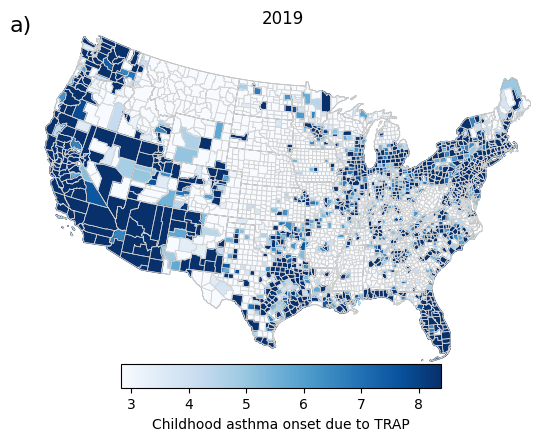

In [7]:
def plot_basemap_county(year, col, state_name = 'NAME', annot='a)', 
                 cmap_title=None, title=None, adjust=True):    
    df = fetch_data(int(year))
    pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
    draw_us_map_county(pop_lookup, df, col, annot='a)', cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    return df

cmap_title = 'Childhood asthma onset due to TRAP'
title = '2019'
df = plot_basemap_county('2019', 'inc_trap', state_name='fips', annot='a)', 
                  cmap_title=cmap_title, title=title, adjust=True)

C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:40: FutureWarning: The fr

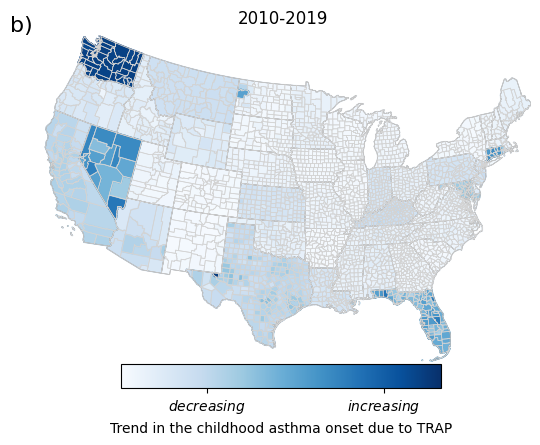

In [8]:
def plot_basemap_county_trend(year, col, state_name = 'NAME', annot='a)', 
                 cmap_title=None, title=None, adjust=True):   
    if state_name == 'fips':
        df = fetch_data_trend(col)
        pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
        draw_us_map_county(pop_lookup, df, col, annot=annot, cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    else:
        df = fetch_data_trend_state(col)
        pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
        pop_lookup['District of Columbia'] = pop_lookup['District Of Columbia']

        draw_us_map(pop_lookup, df, col, annot=annot, cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    return df

cmap_title = 'Trend in the childhood asthma onset due to TRAP'
title = '2010-2019'
df = plot_basemap_county_trend('2019', 'inc_trap', state_name='fips', annot='b)', 
                  cmap_title=cmap_title, title=title, adjust=False)

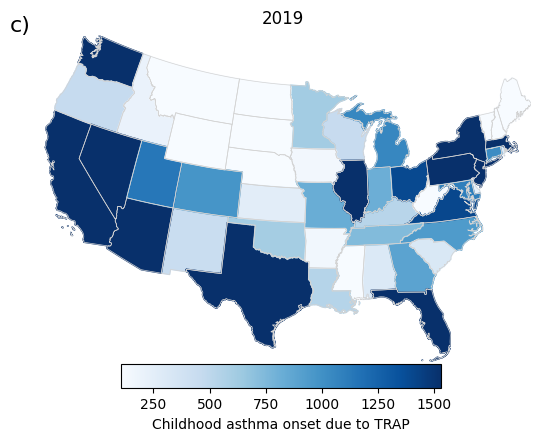

In [9]:
def plot_basemap(year, col, state_name = 'NAME', annot='a)', 
                 cmap_title=None, title=None, adjust=True):    
    df = fetch_data(int(year))
    df = df.groupby(['state_code']).agg({'inc_trap': sum, 'state_name': 'first'}).reset_index()
    pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
    pop_lookup['District of Columbia'] = pop_lookup['District Of Columbia']
    draw_us_map(pop_lookup, df, col, annot=annot, cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    return df

cmap_title = 'Childhood asthma onset due to TRAP'
title = '2019'
df = plot_basemap('2019', 'inc_trap', state_name='state_name', annot='c)', 
                  cmap_title=cmap_title, title=title, adjust=True)

C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The fr

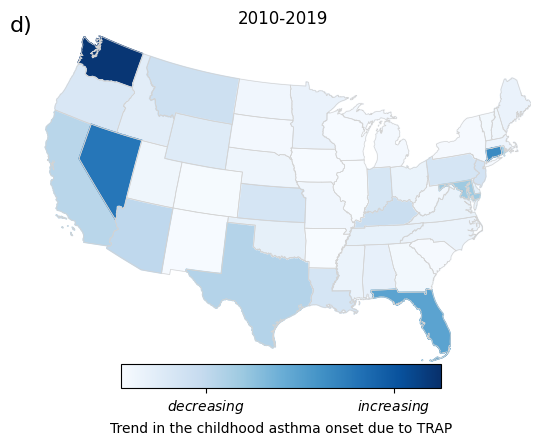

In [10]:
cmap_title = 'Trend in the childhood asthma onset due to TRAP'
title = '2010-2019'
df = plot_basemap_county_trend('2019', 'inc_trap', state_name='state_name', annot='d)', 
                  cmap_title=cmap_title, title=title, adjust=False)

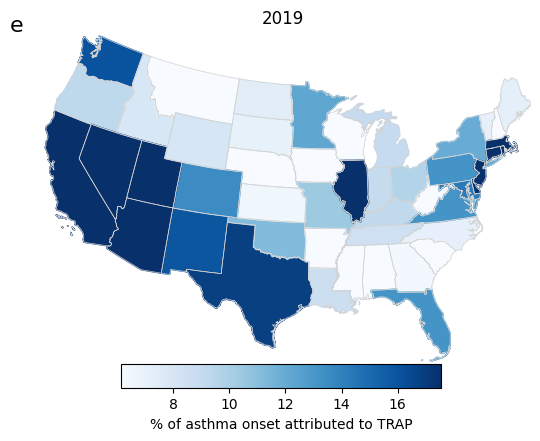

(<mpl_toolkits.basemap.Basemap at 0x1e9fc58f040>,
 (56,
  5,
  [-179.14733999999999, -14.552548999999999, 0.0, 0.0],
  [179.77847, 71.352561, 0.0, 0.0],
  <matplotlib.collections.LineCollection at 0x1e9817c1880>))

In [11]:
cmap_title = '% of asthma onset attributed to TRAP'
title = '2019'
year = '2019'
state_name, col = 'state_name', 'SAF'
df = fetch_data(int(year))
df = df.groupby(['state_code']).agg({'SAF': 'first', 'state_name': 'first'}).reset_index()
df[col] = df[col]*100
pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
pop_lookup['District of Columbia'] = pop_lookup['District Of Columbia']
draw_us_map(pop_lookup, df, col, annot='e', cmap_title=cmap_title, 
                       title=title, adjust=True)

C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  af_df = af_df.append(tdf)
C:\Users\harsh\AppData\Local\Temp\ipykernel_20456\889314304.py:55: FutureWarning: The fr

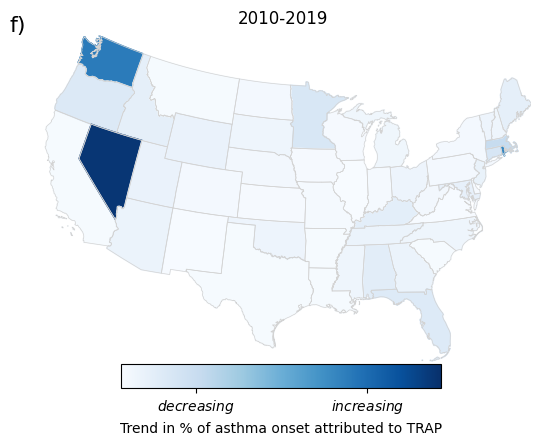

In [12]:
cmap_title = 'Trend in % of asthma onset attributed to TRAP'
title = '2010-2019'
df = plot_basemap_county_trend('2019', 'SAF', state_name='state_name', annot='f)', 
                  cmap_title=cmap_title, title=title, adjust=False)

In [13]:
col='inc_trap'
annot = 'c)'
adjust=True
pop_lookup = {row['fips']:row[col] for index, row in df.iterrows()}

KeyError: 'fips'

In [ ]:
df[df['fips'] == 39071]

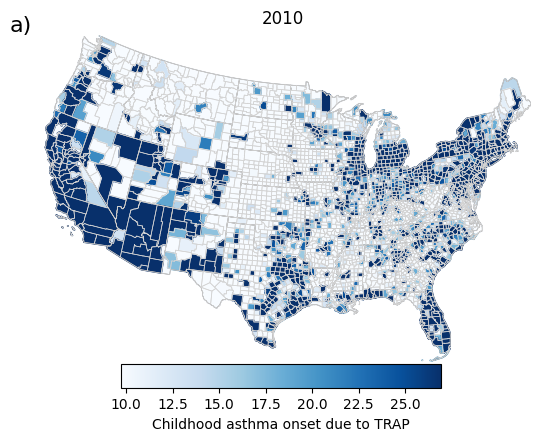

In [15]:
def plot_basemap_county(year, col, state_name = 'NAME', annot='a)', 
                 cmap_title=None, title=None, adjust=True):    
    df = fetch_data(int(year))
    pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
    draw_us_map_county(pop_lookup, df, col, annot='a)', cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    return df

cmap_title = 'Childhood asthma onset due to TRAP'
title = '2010'
df = plot_basemap_county('2010', 'inc_trap', state_name='fips', annot='a)', 
                  cmap_title=cmap_title, title=title, adjust=True)